In [1]:
# Aarya Admane
# TEBD22630 B2 SL2 Prac 12th

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from PIL import Image

100%|██████████| 170M/170M [00:05<00:00, 33.5MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Epoch 1: Train Loss: 1.5492, Train Acc: 43.31% | Val Loss: 1.2300, Val Acc: 54.73%
Epoch 2: Train Loss: 1.2276, Train Acc: 55.89% | Val Loss: 1.0660, Val Acc: 62.09%
Epoch 3: Train Loss: 1.0897, Train Acc: 61.07% | Val Loss: 0.9432, Val Acc: 66.80%
Epoch 4: Train Loss: 1.0079, Train Acc: 64.19% | Val Loss: 0.8791, Val Acc: 69.64%
Epoch 5: Train Loss: 0.9470, Train Acc: 66.39% | Val Loss: 0.8250, Val Acc: 70.97%
Epoch 6: Train Loss: 0.9064, Train Acc: 68.21% | Val Loss: 0.8351, Val Acc: 70.07%
Epoch 7: Train Loss: 0.8695, Train Acc: 69.18% | Val Loss: 0.7725, Val Acc: 72.85%
Epoch 8: Train Loss: 0.8420, Train Acc: 70.52% | Val Loss: 0.7741, Val Acc: 73.24%
Epoch 9: Train Loss: 0.8179, Train Acc: 71.24% | Val Loss: 0.7257, Val Acc: 74.41%
Epoch 10: Train Loss: 0.7929, Train Acc: 72.22% | Val Loss: 0.7209, Val Acc: 75.16%


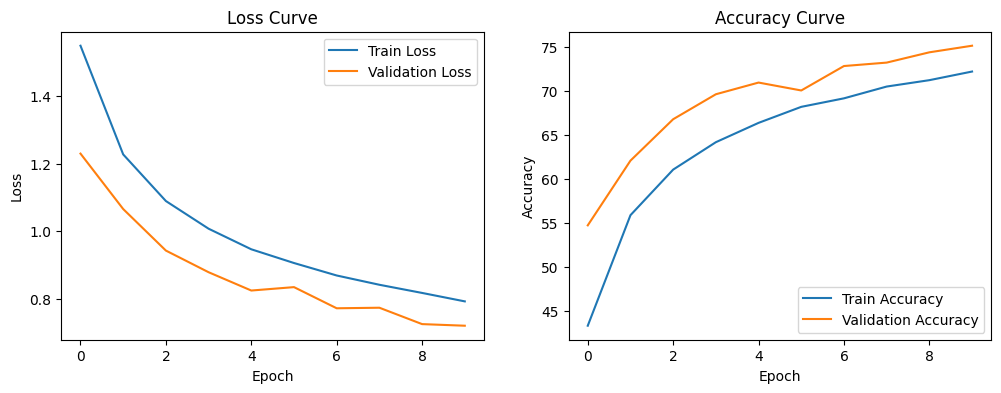


Test Accuracy: 75.16%

Classification Report:

              precision    recall  f1-score   support

    airplane       0.74      0.80      0.77      1000
  automobile       0.82      0.90      0.86      1000
        bird       0.64      0.67      0.66      1000
         cat       0.65      0.50      0.57      1000
        deer       0.75      0.65      0.70      1000
         dog       0.64      0.72      0.67      1000
        frog       0.73      0.87      0.79      1000
       horse       0.86      0.75      0.80      1000
        ship       0.85      0.84      0.85      1000
       truck       0.85      0.81      0.83      1000

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



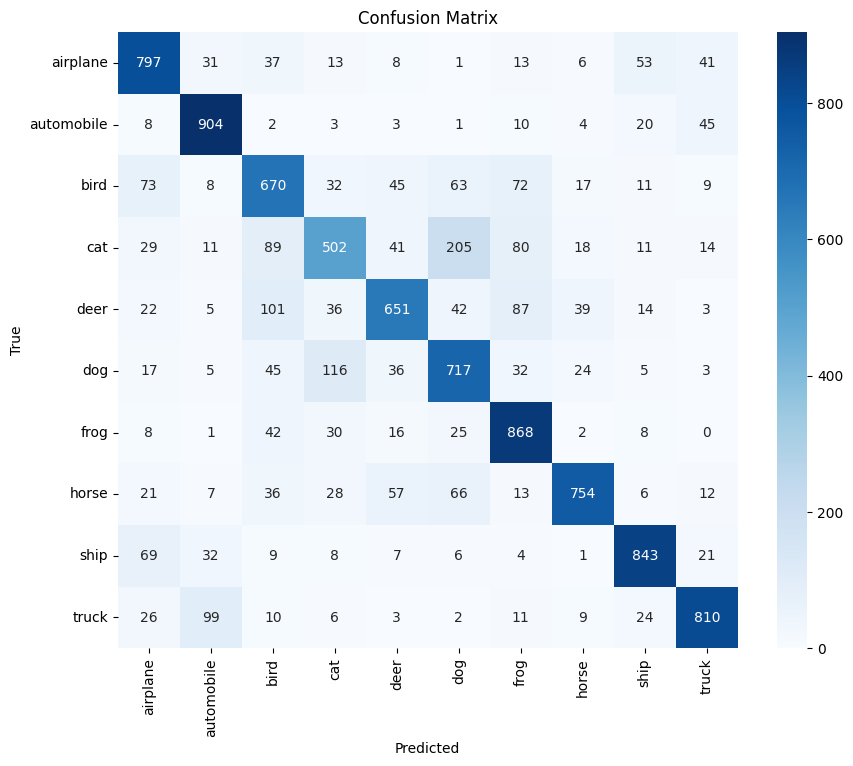

In [ ]:
# Data transformations
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 32x32 → 16x16
        x = self.pool(F.relu(self.conv2(x)))  # 16x16 → 8x8
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Device and setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_acc, val_acc = [], [], [], []

# Training and Validation Loop
for epoch in range(10):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_acc.append(100. * correct / total)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_losses.append(val_loss / len(test_loader))
    val_acc.append(100. * correct / total)

    print(f"Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.2f}%")

# Plotting Loss and Accuracy Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Final Evaluation
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {acc * 100:.2f}%\n")
print("Classification Report:\n")
print(classification_report(all_labels, all_preds, target_names=test_dataset.classes))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



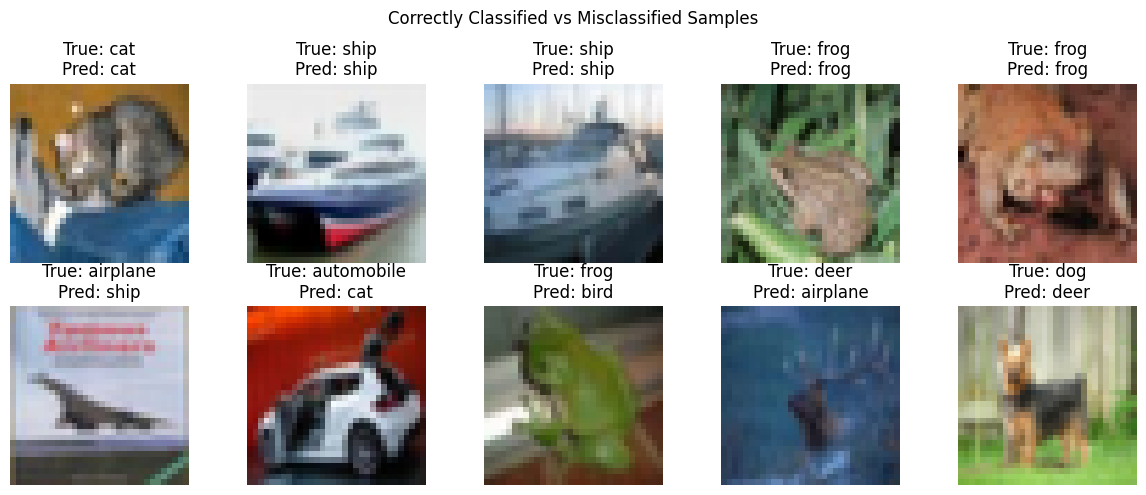

In [ ]:
# Show correct vs incorrect samples
correct_samples = np.array(all_preds) == np.array(all_labels)
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle('Correctly Classified vs Misclassified Samples')
correct_idx = np.where(correct_samples)[0][:5]
wrong_idx = np.where(~correct_samples)[0][:5]

for i, idx in enumerate(correct_idx):
    img, label = test_dataset[idx]
    axs[0, i].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
    axs[0, i].set_title(f"True: {test_dataset.classes[all_labels[idx]]}\nPred: {test_dataset.classes[all_preds[idx]]}")
    axs[0, i].axis('off')

for i, idx in enumerate(wrong_idx):
    img, label = test_dataset[idx]
    axs[1, i].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
    axs[1, i].set_title(f"True: {test_dataset.classes[all_labels[idx]]}\nPred: {test_dataset.classes[all_preds[idx]]}")
    axs[1, i].axis('off')

plt.tight_layout()
plt.show()


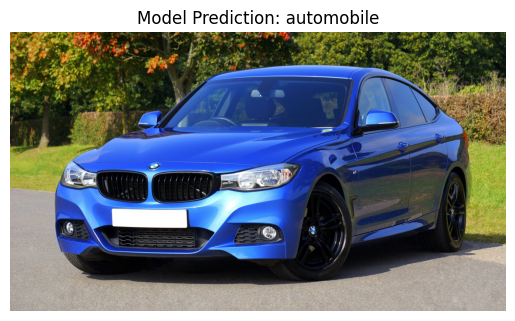

In [4]:
# Predict custom image
user_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

def predict_user_image(img_path, model):
    img = Image.open(img_path).convert('RGB')
    input_tensor = user_transform(img).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)
        pred_class = test_dataset.classes[predicted.item()]
    plt.imshow(img)
    plt.title(f"Model Prediction: {pred_class}")
    plt.axis('off')
    plt.show()

# Example usage
predict_user_image("car.jpg", model)